# Image Classifier - Bird Songs

## Introduction

Our model will take melspgram visualisations of audio segments and classify them as either:
* background (background noise expected in a bush enviroment - winds, insects, etc)
* curlew (eastern curlew)
* whipbird (eastern whipbird)

We will use the Amazon sagemaker built in image classification algorithm

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* Load the Amazon sagemaker image classification docker image

In [4]:
%%time
import boto3
#import re
from sagemaker import get_execution_role
#from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve

role = get_execution_role()

bucket_path="516841648671-sagemaker-birdsong-classifier/melgram-data" # customize to your bucket name and optionally path

#training_image = get_image_uri(boto3.Session().region_name, 'image-classification')
training_image = retrieve("image-classification", boto3.Session().region_name)

print(training_image)

544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/image-classification:1
CPU times: user 103 ms, sys: 16.6 ms, total: 119 ms
Wall time: 166 ms


## Train the Image classification model

The image set we are using consists of x training images and x validation images over 3 categories 
    background
    curlew
    whipbird

In the previous notebook, we collated our dataset into recordio formatted files

The next step is to actually train the model using the data. Before training the model, we need to setup the training parameters. The next section will explain the parameters in detail.


## Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the "InputDataConfig" section. The main parameters that need to be set is the "ContentType" which can be set to "application/x-recordio" or "application/x-image" based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present. 
* **Output specification**: This is specified in the "OutputDataConfig" section. We just need to specify the path where the output can be stored after training
* **Resource config**: This section specifies the type of instance on which to run the training and the number of hosts used for training. If "InstanceCount" is more than 1, then training can be run in a distributed manner. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **image_shape**: The number of channels (3 for colour images), the number of pixels in the X and Y dimensions.
* **num_training_samples**: This is the total number of training samples. It is set to 1875 for the input dataset with the current split
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For worksite safety, we use 2 because it has 2 categories: 0_yeshardhat and 1_nohardhat
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run

In [15]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 101 layers
num_layers = 18
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
# for our dataset this is 5308.
# An easy way to get this is to wc -l dataset_train.lst
num_training_samples = 687
# specify the number of output classes
num_classes = 3
# batch size for training
mini_batch_size =  8
# number of epochs
epochs = 10
# learning rate
learning_rate = 0.01
top_k=2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1
#augmentation_type = "crop_color_transform"

### Create a model using transfer learning

In [17]:
%%time
import time
import boto3
from time import gmtime, strftime

s3 = boto3.client('s3')
# create unique job name 
tl_job_name_prefix = "birdsong-tl-mel-e10-mb8-sz224"
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
tl_job_name = tl_job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket_path, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": tl_job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/'.format(bucket_path),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/'.format(bucket_path),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(tl_job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: birdsong-tl-mel-e10-mb8-sz224-2022-03-17-08-06-30

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://516841648671-sagemaker-birdsong-classifier/melgram-data/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 2.85 ms, sys: 3.41 ms, total: 6.25 ms
Wall time: 5.88 ms


#### After setting training parameters, we kick off training, and poll for status until training is completed

In [ ]:
%%time
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=tl_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=tl_job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=tl_job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=tl_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress


### Create a model without transfer learning

In [ ]:
use_pretrained_model = 0

In [ ]:
%%time
import time
import boto3
from time import gmtime, strftime

s3 = boto3.client('s3')
# create unique job name 
no_tl_job_name_prefix = "birdsong-no-tl-mel-e10-mb8-sz224"
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
no_tl_job_name = no_tl_job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket_path, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": no_tl_job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/'.format(bucket_path),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/'.format(bucket_path),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(no_tl_job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

In [ ]:
%%time
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=no_tl_job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=no_tl_job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=no_tl_job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=no_tl_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

If you see the message,

> `Training job ended with status: Completed`

then that means training sucessfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

This section involves several steps,

1. [Create Model](#CreateModel) - Create model for the training output
1. [Create Endpoint Configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create Endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform Inference](#Perform Inference) - Perform inference on some input data using the endpoint.

## Create Model based on Transfer Learning training job

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

tl_model_name="birdsong-mel-model-epoch10-bs8-tl-sz224"
print(tl_model_name)
info = sage.describe_training_job(TrainingJobName=tl_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

#hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')
hosting_image = retrieve("image-classification", boto3.Session().region_name)

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = tl_model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

## Create Model based on No Transfer Learning training job

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

no_tl_model_name="birdsong-mel-model-epoch10-bs8-no-tl-sz224"
print(no_tl_model_name)
info = sage.describe_training_job(TrainingJobName=no_tl_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

#hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')
hosting_image = retrieve("image-classification", boto3.Session().region_name)

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = no_tl_model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

### Create Endpoint Configuration for Transfer Learning job
Sagemaker supports configuring REST endpoints hosting multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [ ]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
tl_endpoint_config_name = tl_job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = tl_endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':tl_model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(tl_endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

### Create Endpoint Configuration for No Transfer Learning job
Sagemaker supports configuring REST endpoints hosting multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [ ]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
no_tl_endpoint_config_name = no_tl_job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = no_tl_endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':no_tl_model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(no_tl_endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

### Create Endpoint for TL job
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [ ]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
tl_endpoint_name = tl_job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(tl_endpoint_name))

endpoint_params = {
    'EndpointName': tl_endpoint_name,
    'EndpointConfigName': tl_endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

### Create Endpoint for No TL job
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [ ]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
no_tl_endpoint_name = no_tl_job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(no_tl_endpoint_name))

endpoint_params = {
    'EndpointName': no_tl_endpoint_name,
    'EndpointConfigName': no_tl_endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

#### Wait for Transfer Learning endpoint creation to complete
Let's check the status of the endpoint and wait for creation to complete

In [63]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=tl_endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=tl_endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=tl_endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


#### Wait for No Transfer Learning endpoint creation to complete
Let's check the status of the endpoint and wait for creation to complete

In [63]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=no_tl_endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=no_tl_endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=no_tl_endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

In [64]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

### Download test images
This is where you will have a bunch of jpeg images for testing. 
Make sure the images are of the correct dimensions (max 224x224 pixels for this model)

Now let's display and run inference on a few of our test images

In [32]:
!aws s3 cp --recursive s3://516841648671-sagemaker-birdsong-classifier/images-validation /tmp/test #Change the name of the bucketpath

### Validate TL Model
We will now validate the model for use. Obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.

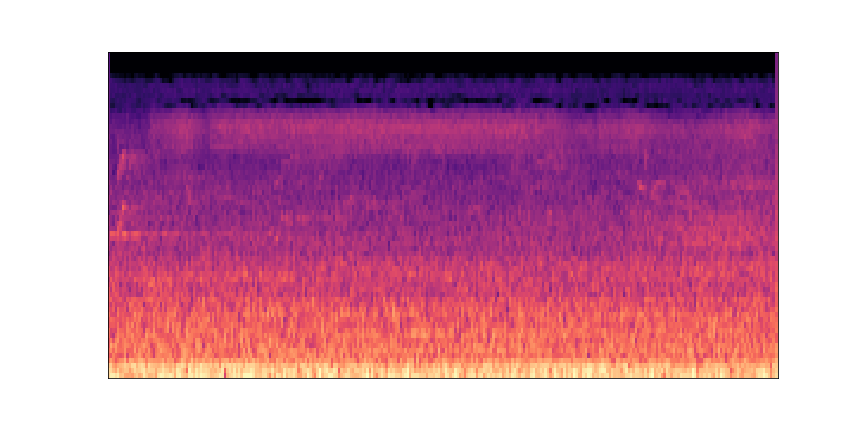

Result: label - background, probability - 0.9987215399742126


In [68]:
import json
import numpy as np
from IPython.display import Image

file_name = 'Validation-images/background_2_stereo_98000_101000.png'
display(Image(file_name,width=200))

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=tl_endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
inference_categories = ['background', 'curlew', 'whipbird']
print("Result: label - " + inference_categories[index] + ", probability - " + str(result[index]))

### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)